In [82]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
#from ipyleaflet import *
#from ipywidgets import Layout
import os
from sklearn.cluster import DBSCAN
from sklearn import metrics
from geopy.distance import great_circle
from shapely.geometry import MultiPoint
import pyodbc
from pyproj import Transformer

%matplotlib inline
%load_ext line_profiler

In [3]:
#find working folder
dir_path = os.getcwd()

In [4]:
def gen_spatial_data():
    sz = 13**3
    df = pd.DataFrame(np.random.randint(240000,380000, (sz, 1)), columns=['EASTING'])
    df['NORTHING'] = np.random.randint(35000, 150000, (sz, 1))
    df['ERS_TYPE'] = np.random.choice(['DWELLING', 'RTC'], len(df))
    #df['date'] = pd.date_range('2000-01-01', freq='1S', periods=len(df))
    #df['dt2'] = pd.date_range('1980-01-01', freq='999S', periods=len(df))
    #df['f1'] = np.random.rand(len(df))
    #df['f2'] = np.random.rand(len(df))
    return df

In [5]:
# connection to server and databse
try:
    conn = pyodbc.connect("Driver={SQL Server Native Client 11.0};"
                      "Server=SQL1\\LIVE1;"
                      "Database=CommonData;"
                      "Trusted_Connection=yes;",
                       timeout=1)
    # Read the sql file
    query = open(dir_path + '/' + 'ers_failures.sql', 'r')
    # read the sql query and connection and create a dataframe
    df = pd.read_sql(query.read(), conn)
    # convert x/y columns to number from text
    df[["EASTING", "NORTHING"]] = df[["EASTING", "NORTHING"]].apply(pd.to_numeric)
except:
    #print("Connetion to Database timed out")
    df = gen_spatial_data()
#print(df.info())

In [ ]:
#%timeit df

In [7]:
def vectorized_convert(df):
    transformer = Transformer.from_crs("epsg:27700", "epsg:4326")
    converted = transformer.transform(df['EASTING'].tolist(), df['NORTHING'].tolist())
    df['lat'] = converted[1]
    df['lon'] = converted[0]
    return df
vec = vectorized_convert(df)
#%lprun -f vectorized_convert vectorized_convert(vec)

In [9]:
vec = gpd.GeoDataFrame(vec, geometry=gpd.points_from_xy(vec['lat'], vec['lon']),crs="EPSG:4326")

In [10]:
# read boundary into dataframe and transform
service_area = gpd.read_file(dir_path + "/data/geospatial/DSFRS_Service_Area.shp")
service_area = service_area.to_crs(epsg=4326)
#transformer = Transformer.from_crs("epsg:27700", "epsg:4326")
#boundary = transformer.transform(boundary['geometry'])

# combine and filter points within boundary
vec = gpd.sjoin(vec, service_area, how="inner", op='within')
vec

,INCIDENT_NUMBER,CALL_TIME,FINANCIAL_YEAR,ERS_TYPE,EASTING,NORTHING,lat,lon,geometry,index_right,cat,ID
0,HV037231-23022019,2019-02-23 00:45:46.683,2018/19,DWELLING,246081,57495,-4.166972,50.397130,POINT (-4.16697 50.39713),0,1,0
1,HV037232-23022019,2019-02-23 00:45:42.793,2018/19,DWELLING,245967,57406,-4.168539,50.396300,POINT (-4.16854 50.39630),0,1,0
2,TV015277-18082018,2018-08-18 18:08:05.547,2018/19,DWELLING,344177,108819,-2.794785,50.876158,POINT (-2.79479 50.87616),0,1,0
3,TV026891-08012019,2019-01-08 19:14:10.067,2018/19,DWELLING,298425,96725,-3.441538,50.761198,POINT (-3.44154 50.76120),0,1,0
4,TV026939-08012019,2019-01-08 23:40:54.317,2018/19,DWELLING,330452,149892,-2.997740,51.243945,POINT (-2.99774 51.24395),0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
916,VV038422-28032019,2019-03-28 18:25:32.883,2018/19,DWELLING,333774,105905,-2.942096,50.848857,POINT (-2.94210 50.84886),0,1,0
917,VV038453-29032019,2019-03-29 01:33:37.527,2018/19,DWELLING,265593,94842,-3.906114,50.737592,POINT (-3.90611 50.73759),0,1,0
918,VV038720-15032020,2020-03-15 18:41:17.693,2019/20,RTC,327429,112810,-3.033583,50.910177,POINT (-3.03358 50.91018),0,1,0
919,VV039318-22032020,2020-03-22 17:02:38.913,2019/20,DWELLING,348519,150218,-2.738983,51.248797,POINT (-2.73898 51.24880),0,1,0


In [11]:
coords = vec[['lat', 'lon']].values
miles = 2
conversion_factor = 0.62137119
kilometers = miles / conversion_factor
kms_per_radian = 6371.0088
epsilon = kilometers / kms_per_radian
db = DBSCAN(eps=epsilon, min_samples=12, metric='haversine', algorithm='ball_tree').fit(np.radians(coords))
cluster_labels = db.labels_
#print(cluster_labels)

In [12]:
# calculate the number of clusters
num_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
print('Number of clusters: {}'.format(num_clusters))
clusters = pd.Series([coords[cluster_labels == n] for n in range(num_clusters)])
print(clusters)
# identify core points
core_points = np.zeros_like(cluster_labels, dtype = bool)
core_points[db.core_sample_indices_] = True
#print(core_points)
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(coords, cluster_labels))

Number of clusters: 7
0    [[-2.945558441726794, 51.23744538894077], [-2....
1    [[-3.6518203950564305, 50.51049233612191], [-3...
2    [[-3.5161100671119274, 50.46373782748626], [-3...
3    [[-3.6866836647381134, 50.43006440795513], [-3...
4    [[-4.1669722748369775, 50.39712980254106], [-4...
5    [[-4.042645153505853, 50.380537480849995], [-4...
6    [[-3.5013258725719703, 50.72647567256655], [-3...
dtype: object
Silhouette Coefficient: -0.436


In [13]:
def get_centermost_point(cluster):
    centroid = (MultiPoint(cluster).centroid.x, MultiPoint(cluster).centroid.y)
    centermost_point = min(cluster, key=lambda point: great_circle(point, centroid).m)
    return tuple(centermost_point)
centermost_points = clusters.map(get_centermost_point)
#print(centermost_points)
#centermost_points.to_csv("centre.csv", index=False)
lats, lons = zip(*centermost_points)
rep_points = pd.DataFrame({'lat':lats, 'lon':lons})
rs = rep_points
#rs = rep_points.apply(lambda row: df[(df['lat']==row['lat']) &amp;&amp; (df['lon']==row['lon'])].iloc[0], axis=1)

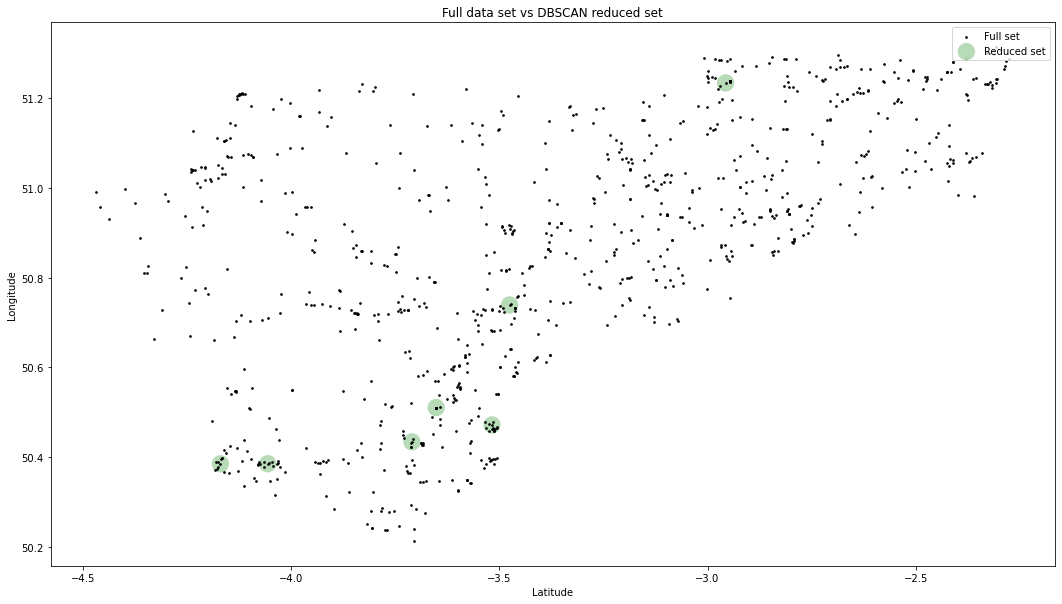

In [14]:
fig, ax = plt.subplots(figsize=[18, 10])
rs_scatter = ax.scatter(rs['lat'], rs['lon'], c='#99cc99', edgecolor='None', alpha=0.7, s=300)
df_scatter = ax.scatter(vec['lat'], vec['lon'], c='k', alpha=0.9, s=3)
ax.set_title('Full data set vs DBSCAN reduced set')
ax.set_xlabel('Latitude')
ax.set_ylabel('Longitude')
ax.legend([df_scatter, rs_scatter], ['Full set', 'Reduced set'], loc='upper right')
plt.show()

In [15]:
#gdf = gpd.GeoDataFrame(rs, geometry=gpd.points_from_xy(rs['lat'], rs['lon']),crs="EPSG:4326")

#geo_data = GeoData(geo_dataframe = gdf,
#                   style={'color': 'black', 'fillColor': '#3366cc', 'opacity':0.05, 'weight':1.9, 'dashArray':'2', 'fillOpacity':0.6},
#                   hover_style={'fillColor': 'red' , 'fillOpacity': 0.2},
#                   name = 'Countries')

In [19]:
mask = vec['ERS_TYPE'] == 'DWELLING'
dwl = vec[mask]
rtc = vec[~mask]

In [84]:
import folium
import webbrowser
# Build map 
m = folium.Map(location=(50.909614, -3.48), zoom_start=9, zoomSnap=0.1, zoomDelta=0.5, tiles=None, control_scale=True, layer_name = 'Shaking Intensity')
folium.TileLayer('cartodbpositron',name='Greyscale').add_to(m)

# set custom name for base layer
#m = folium.Map((0, 0), tiles=None)
#folium.TileLayer('cartodbpositron', name='my tilelayer').add_to(m)

layer = folium.FeatureGroup(name='Clusters', show=True)
layer2 = folium.FeatureGroup(name='Dwl Fires', show=True)
layer3 = folium.FeatureGroup(name='RTCs', show=True)


# add marker one by one on the map
for i in range(0,len(rs)):
   folium.CircleMarker(location=[rs.iloc[i]['lon'], rs.iloc[i]['lat']], radius=12, stroke=True, color='firebrick', weight=3, fill=True,
      fill_color='firebrick', fillOpacity=1).add_to(layer)

# add marker one by one on the map
for i in range(0,len(dwl)):
   folium.CircleMarker(location=[dwl.iloc[i]['lon'], dwl.iloc[i]['lat']], radius=3, stroke=False, color='#fffa76', opacity=0.8, weight=2, fill=True,
      fill_color='#fffa76', fillOpacity=1).add_to(layer2)

# add marker one by one on the map
for i in range(0,len(rtc)):
   folium.CircleMarker(location=[rtc.iloc[i]['lon'], rtc.iloc[i]['lat']], radius=3, stroke=False, color='#f676ff', opacity=0.8, weight=2, fill=True,
      fill_color='#f676ff', fillOpacity=1).add_to(layer3)

sw = vec[['lon', 'lat']].min().values.tolist()
ne = vec[['lon', 'lat']].max().values.tolist()

m.fit_bounds([sw, ne])
style = {'color': '#a9a9a9', 'fillColor': '#f5f5f5' }  # 'lineColor': '#ffffbf' blue
folium.GeoJson(service_area, name='Service_Area', style_function = lambda x: style).add_to(m)
layer.add_to(m)
layer2.add_to(m)
layer3.add_to(m)

#folium.GeoJson(service_area).add_to(m)
folium.map.LayerControl('topright', collapsed=True).add_to(m) #, hideSingleBase=True
#folium.LayerControl().add_to(m)
m

In [ ]:
#m.save('plot_data.html')
# Import the Folium interactive html file
#from IPython.display import HTML
#HTML('<iframe src=plot_data.html</iframe>')
#webbrowser.open('plot_data.html', new=2) 